## Import

In [39]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)


pd.set_option('display.max_colwidth', None)

## Read data

In [40]:
df_anxiety = pd.read_csv('Anxiety.csv')
df_ptsd = pd.read_csv('PTSD.csv')

df_anxiety = df_anxiety.drop(columns = 'Unnamed: 0')
df_ptsd.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.concat([df_ptsd,df_anxiety])
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [41]:
df.shape

(20298, 5)

## Exploratory Data Analysis 

### Visualising differences in user activity levels

In [42]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic","'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
for head in headers:
    stopwordlist.append(head)


# Add additional list from stemmed words 

stemmed_data = ['abov', 'ani', 'anxieti', 'becaus', 'befor', 'disord', 'dure', 'hi', 'onc', 'onli', 'ourselv', 'posttraumat', 'themselv', 'thi', 'traumat', 'veri', 'whi', 'yourselv', 'becau']
for stem in stemmed_data:
    stopwordlist.append(stem)

stopwordlist


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
df.head()

,subreddit,selftext,title,created_utc,datetime
0,ptsd,"So, I was on tick-tock and a therapist was talking about healing PTSD and I don't know if it's my night shift brain but I thought I kinda had PTSD forever now? Like.yeah.i can learn to love with it but I wouldn't class that as healing it? Idek I'm confused and sleepy sorry for the ramble!",Can PTSD be healed?,1647751986,2022-03-20 04:53:06
1,ptsd,"I just need to share this and my feelings about it somewhere. It's too personal for my regular social media but I have to put it into writing in some way.\n\nI've been avoiding googling my abusive ex boyfriend for ten years. Just thinking about him made me sick. Two years ago I finally got trauma therapy to deal with what he did to me. Constant humiliation, degradation, sexual abuse and rape. \n\nTonight I randomly felt curious about where he would be in life now, so I googled him. Turns out he died two years ago, about the same time as my trauma therapy started. I found this webpage where his friends and family had written how much they missed him. How they'd never forget his smile, the same smile that makes my skin crawl just thinking about it. \n\nI've never felt happy about anyone's death before but I actually feel like celebrating. It's not relief because he was already out of my life and I was never scared of him showing up or hurting me again. It's just.. triumph. I still suffer the consequences of what he did to me. I still can't make relationships work and I still flinch when men get close to touching me because of him. I'm not ashamed to say that I hope he suffered before he died.\n\nThere's not much to discuss here I guess, I just didn't know where else to share this honestly.",Just found out my abuser is dead,1647747979,2022-03-20 03:46:19
2,ptsd,"I was kidnapped at the age of 22 by a psychotic maniac on the run from the law and held against my will for 11 months\nIt was hell. Everyday was hell. Of course I now have complex PTSD. I'm 64 now and am still traumatized. My whole life was ruined by the time I was 23. I never got married, never had kids. I've been a loner ever since. I still get intrusive memories of horrific child abuse. I don't know why I'm even posting this. But I know people here understand.",PTSD never goes away... I'm tired of it,1647747031,2022-03-20 03:30:31
3,ptsd,"As soon as I sit down with a counselor, I begin to shake uncontrollably, and it doesn't end until the appointment ends.",Do you shake uncontrollably during therapy?,1647743359,2022-03-20 02:29:19
4,ptsd,The guy I work for abuses me and I can't get away from him. Everyone around me keeps saying I'll be ok one day but I don't believe that at all. I'm just gonna stop thinking about all of this because ignoring it has been one of the only things that have worked so far. I know I'll be fine if I just stop thinking.,I'm just going to stop thinking about it,1647743100,2022-03-20 02:25:00


In [44]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'ptsd' else 0)

In [45]:
X = df['selftext']
y = df['subreddit']

#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [46]:
vectorizer = TfidfVectorizer(stop_words=stopwordlist)    


In [47]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

MultinomialNB()

In [48]:
df['subreddit'].value_counts(normalize= True)

1    0.501921
0    0.498079
Name: subreddit, dtype: float64

In [49]:
clf.predict(X_train)


array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [50]:
vectorizer.get_feature_names()[0]

'00'

In [51]:
# Test the prediction
# for first row, seeing prob of getting PTSD given using the word for 00 is higher than of given not PTSD
clf.predict_proba(X_train[0, :])


array([[0.27340891, 0.72659109]])

In [52]:
df.shape

(20298, 5)

In [53]:
# need to do todense() because after we vectorise, it is in a sparse matrix
# hence in order to read, we do todense

X_train.todense().shape

(13599, 28788)

In [54]:
# two rows of probabilities 
# first is for 0 (NOT PTSD)
# second is for 1 (PTSD)

clf.feature_log_prob_.shape

(2, 28788)

In [55]:
print(f'Log prob given not PTSD: {clf.feature_log_prob_[1, :]}') 

print(f'Log prob given PTSD: {clf.feature_log_prob_[0, :]}') 

Log prob given not PTSD: [-10.50472799 -10.41688442 -11.23886477 ... -11.23886477 -11.23886477
 -11.23886477]
Log prob given PTSD: [ -9.55622364 -10.11461905 -10.79921798 ... -10.99118709 -10.99118709
 -10.99118709]


In [56]:
delta = clf.feature_log_prob_[1, :] - clf.feature_log_prob_[0, :]


df_multinomial = pd.DataFrame([[x,y] for x,y in zip(vectorizer.get_feature_names(),delta)])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(20)

,Features,log_prob_diff
10340,flashbacks,3.671784
10338,flashback,3.394755
20389,raped,3.251154
20387,rape,3.243639
1116,abuser,3.173942
2492,assault,3.074608
1115,abused,2.947430
2493,assaulted,2.771845
1114,abuse,2.669279
17140,nightmares,2.541429


In [57]:
X = df['selftext']
y = df['subreddit']

class LemmaTokenizer(object):
    def __init__(self):
        self.stem = PorterStemmer()
    def __call__(self,articles):
        return [self.stem.stem(t) for t in word_tokenize(articles)]


#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words = stopwordlist, tokenizer= LemmaTokenizer())),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [1_000],
    'cvec__min_df': [.002],
    'cvec__max_df': [.6],
    'cvec__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
  

In [58]:
gs.best_estimator_


Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.6, max_features=1000, min_df=0.002,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x00000298490EB970>)),
                ('nb', MultinomialNB())])

In [59]:
# What's the best score?
print('Best score:', gs.best_score_)

# Score model on training set.
print('Best training score:', gs.score(X_train, y_train))
  
# Score model on testing set.
print('Best test score:', gs.score(X_test, y_test))

Best score: 0.7998381487571122
Best training score: 0.8080005882785499
Best test score: 0.8087774294670846


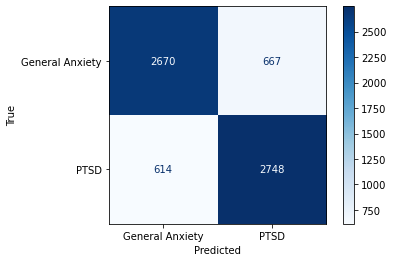

In [60]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [64]:
# to create delta between the log probabilities between two classes
delta = gs.best_estimator_[1].feature_log_prob_[1, :] - gs.best_estimator_[1].feature_log_prob_[0, :]

# Create Df and filter top few log prob 
df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), np.exp(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'Probability_PTSD'}, inplace = True)
df_multinomial.sort_values(by = 'Probability_PTSD', ascending = False).head(30)


,Features,Probability_PTSD
356,flashback,57.169785
706,rape,55.580035
103,assault,29.973813
42,abus,14.869021
293,emdr,11.873103
778,sexual,10.409478
608,nightmar,8.225898
937,victim,7.568245
260,dissoci,6.386084
562,memori,6.039942


In [62]:
def lemmetize_print(words):
     from nltk.stem import WordNetLemmatizer
     from nltk.tokenize import word_tokenize
     lemmatizer = WordNetLemmatizer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          if token in ['abused']:
              a.append('abuse')
          lemmetized_word = lemmatizer.lemmatize(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)



text = 'flashbacks flashback abused'

lemmetize_print(text)

flashback flashback abuse abused


In [63]:
stemmer = PorterStemmer()


def lemmetize_print(words):
     stemmer = PorterStemmer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          lemmetized_word = stemmer.stem(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)


text = 'flashbacks flashback abuser'

lemmetize_print(text)

flashback flashback abus
